# The modular biochemical reaction network structure of cellular translation

## Abstract

Translation is an essential attribute of all living cells. At the heart of cellular operation, it is a chemical information decoding process that begins with an input string of nucleotides and ends with the synthesis of a specific output string of peptides. The translation process is interconnected with gene expression, physiological regulation, transcription, and responses to signaling molecules, among other cellular functions. Foundational efforts have uncovered a wealth of knowledge about the mechanistic functions of and many interactions between components of translation, but the broader biochemical connections between translation, metabolism and polymer biosynthesis that enable translation to occur have not been comprehensively mapped. Here we present a multilayer graph of biochemical reactions describing the translation, polymer biosynthesis and metabolism networks of an Escherichia coli cell. Intriguingly, the compounds that compose these three layers are distinctly aggregated into three modes regardless of their layer categorization. Multimodal mass distributions are well-known in ecosystems, but this is the first such distribution reported at the biochemical level. The connectivity distributions of the translation and metabolic networks are each likely to be heavy-tailed, but the polymer biosynthesis network is not. A multimodal mass-connectivity distribution indicates that the translation and metabolism networks are each distinct, adaptive biochemical modules, and that the gaps between the modes reflect evolved responses to the functional use of metabolite, polypeptide and polynucleotide compounds. The chemical reaction network of cellular translation opens new avenues for exploring complex adaptive phenomena such as percolation and phase changes in biochemical contexts. 



In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import powerlaw as plw
import seaborn as sns
from Bio.SeqUtils import molecular_weight
from rdkit import Chem as chem
from rdkit.Chem.Descriptors import ExactMolWt
import json
import re
# import plotly.express as px

sns.set_style('darkgrid')


palette = dict(
    metabolite='#102ECC',
    protein='#596399',
    assembly='#64f195',
    RNA='#FFA86E',
    ion='#CC4010',
    
)

## Flux between networks (Fig 3. B)

The following block retrieves how many compounds link each of the layers of the full network. We represented the numerical values of this analysis in Figure 3B.

In [7]:
TMNI = nx.read_gml('networks/full-network.gml')

flux_dictionary = dict(
    metabolism = {"metabolism":0, "biosynthesis":0, "translation":0},
    biosynthesis = {"metabolism":0, "biosynthesis":0, "translation":0},
    translation = {"metabolism":0, "biosynthesis":0, "translation":0},
)


for node, node_data in TMNI.nodes(data=True):
    if node_data['type'] == 'chemical_entity':
        production_levels = []
        consumption_levels = []
        for reaction in TMNI.predecessors(node):
            i = TMNI.nodes()[reaction]['domain']
            if i not in production_levels: production_levels.append(i)
        for reaction in TMNI.successors(node):
            i = TMNI.nodes()[reaction]['domain']
            if i not in consumption_levels: consumption_levels.append(i)

        for p in production_levels:
            for c in consumption_levels:
                flux_dictionary[p][c] += 1


np.set_printoptions(formatter={'float_kind':'{:6.3f}'.format})
pd.DataFrame.from_records(flux_dictionary)
        

,biosynthesis,metabolism,translation
metabolism,1021,1054,27
biosynthesis,426,0,1
translation,17,25,357


## Statistical Network Properties: degree and mass distributions (Fig 5 A, B, C and D)

The following blocks provide the analysis of the two main attributes under study: the mass and the connectivity. For the analysis of the degree distribution, we extract the degree as the number of times that each compound interacts with reactions from a specific layer (or any of them, in the case of the full-network). For the mass, we rely in the mass that we have annotated for each of the compounds during the construction of the network.

In [8]:
def extract_connectivity_values(G: nx.DiGraph, reaction_domain=None):
    out = []
    for node, node_data in G.nodes(data=True):
        if node_data['type'] == 'chemical_entity':
            
            degree_in = 0
            degree_out = 0
            for reaction in G.predecessors(node):
                domain = G.nodes()[reaction]['domain']
                if domain == reaction_domain or reaction_domain is None:
                    degree_in += 1
            for reaction in G.successors(node):
                domain = G.nodes()[reaction]['domain']
                if domain == reaction_domain or reaction_domain is None:
                    degree_out += 1

            if degree_in == 0 and degree_out == 0:
                continue
            else:
                
                try:
                    compound_type = node_data['compound_type']
                except KeyError:
                    compound_type = None

                try:
                    mass = float(node_data['mass'])
                except KeyError:
                    mass = None

                out.append(dict(
                    label=node,
                    degree_in = degree_in,
                    degree_out = degree_out,
                    degree_total = degree_in + degree_out,
                    weight = mass,
                    compound_type=compound_type,
                    domain=reaction_domain
                ))

    return pd.DataFrame.from_records(out)

In [9]:
TMNI = nx.read_gml('networks/full-network.no-connections.gml')
translation_network_attributes = extract_connectivity_values(TMNI, reaction_domain='translation')
metabolism_network_attributes = extract_connectivity_values(TMNI, reaction_domain='metabolism')
biosynthesis_network_attributes = extract_connectivity_values(TMNI, reaction_domain='biosynthesis')
full_network_attributes = extract_connectivity_values(TMNI, reaction_domain=None)

In [10]:
tn_plf = plw.Fit(translation_network_attributes.degree_total.values, discrete=True, xmin=1)
mn_plf = plw.Fit(metabolism_network_attributes.degree_total.values, discrete=True, xmin=1)
ba_plf = plw.Fit(biosynthesis_network_attributes.degree_total.values, discrete=True, xmin=1)
an_plf = plw.Fit(full_network_attributes.degree_total.values, discrete=True, xmin=1)


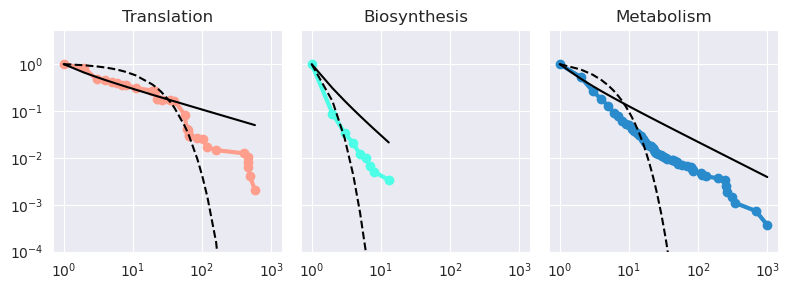

In [12]:
fig, ax = plt.subplots(1, 3, sharey=True, sharex=True)
fig.set_size_inches(8, 3)

ax[0].grid(True)
ax[1].grid(True)
ax[2].grid(True)


tn_plf.plot_ccdf(color='#FF9E8C', label='empirical', ax=ax[0], marker='o', linewidth=3)
tn_plf.power_law.plot_ccdf(color='black', label='power-law', ax=ax[0])
tn_plf.exponential.plot_ccdf(color='black', linestyle='--', label='exponential', ax=ax[0])

ba_plf.plot_ccdf(color='#4DFFE6', label='empirical', ax=ax[1], marker='o', linewidth=3)
ba_plf.power_law.plot_ccdf(color='black', label='power-law', ax=ax[1])
ba_plf.exponential.plot_ccdf(color='black', linestyle='--', label='exponential', ax=ax[1])

mn_plf.plot_ccdf(color='#298ACC', label='empirical', ax=ax[2], marker='o', linewidth=3)
mn_plf.power_law.plot_ccdf(color='black', label='power-law', ax=ax[2])
mn_plf.exponential.plot_ccdf(color='black', linestyle='--', label='exponential', ax=ax[2])

ax[0].set_title('Translation')
ax[1].set_title('Biosynthesis')
ax[2].set_title('Metabolism')
fig.tight_layout()


ax[0].set_ylim(10**-4, None)
fig.tight_layout()
plt.show()


**Figure 5.A** Degree distribution per layers. Y-axis represents the cumulative complementary distribution function, and the X-axis the of each compounds degree. The different plots divide the network by its layers.

In [13]:
def generate_record(plf, layer, dist1, dist2):
    ratio, pvalue = plf.loglikelihood_ratio(dist1, dist2)
    alpha = plf.power_law.alpha
    most_likely = lambda x, value: x[0] if value > 0.0 else x[1]
    
    return dict(
        layer=layer, distribution1=dist1, distribution2=dist2, 
        most_likely_distribution=most_likely([dist1, dist2], ratio),
        pvalue=pvalue, ratio=ratio, alpha=alpha
    )


In [14]:
pd.DataFrame.from_records([
    generate_record(mn_plf, 'metabolism', 'exponential', 'power_law'),
    generate_record(ba_plf, 'biosynthesis', 'exponential', 'power_law'),
    generate_record(tn_plf, 'translation', 'exponential', 'power_law'),
    generate_record(an_plf, 'all-layers', 'exponential', 'power_law'),
])

,layer,distribution1,distribution2,most_likely_distribution,pvalue,ratio,alpha
0,metabolism,exponential,power_law,power_law,2.062517e-05,-1484.493098,1.747006
1,biosynthesis,exponential,power_law,exponential,3.652707e-01,24.102069,2.279500
2,translation,exponential,power_law,power_law,2.885887e-06,-247.869332,1.433636
3,all-layers,exponential,power_law,power_law,7.430913e-15,-2508.306005,1.690294


**Table 1**: Statistical fits of each of the degree distributions. The alpha value corresponds to the exponent of the fitted power-law.

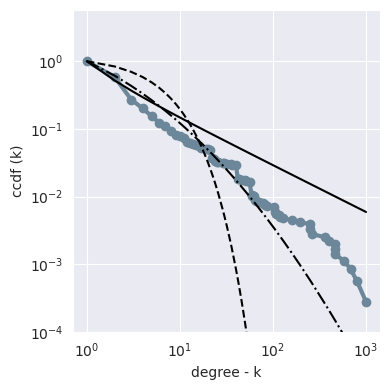

In [15]:
fig, ax = plt.subplots(1)
fig.set_size_inches(4, 4)
an_plf.plot_ccdf(color='#6B8799', label='empirical', ax=ax, marker='o', linewidth=3)
an_plf.power_law.plot_ccdf(color='black', label='power-law', ax=ax)
an_plf.lognormal.plot_ccdf(color='black', label='log-normal', linestyle='-.', ax=ax)
an_plf.exponential.plot_ccdf(color='black', linestyle='--', label='exponential', ax=ax)
ax.set_ylim(10**-4, None)
ax.set_xlabel('degree - k')
ax.set_ylabel('ccdf (k)')
plt.savefig('figures/power_law.full.svg', dpi=300)
plt.tight_layout()
plt.show()

**Figure S1**. Degree distribution of the full-network, using the same layout as in **Figure 5.A**

### Mass distribution

We use the degree as a way to weight the distribution, so instances that have a higher degree are more represented in the histogram. If we compute the property p(x), then:

$$ p(x) = \frac{1}{D} \sum_{i}^{Vertex} \delta (y - x) p_i(y) d_i $$

Where:

- p(x): histogram value at x
- $\delta(y - x)$: delta function
- $p_i(y)$: property function of node i.
- $d_i$: Degree of node i.
- $D$: Total degree

In [16]:
full_network_attributes['log_weight'] = np.log10(full_network_attributes['weight'])
full_network_attributes['log_degree'] = np.log10(full_network_attributes['degree_total'])

/home/bcz/miniconda3/envs/tn2022/lib/python3.11/site-packages/seaborn/distributions.py:407: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"


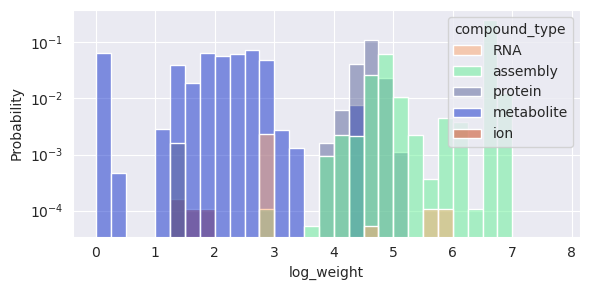

In [17]:
bins=np.arange(0, 8, 0.25)
fig, ax = plt.subplots(1)
fig.set_size_inches(6.0, 3.0)
sns.histplot(
    x='log_weight', stat='probability', bins=bins, weights='degree_total',
    data=full_network_attributes.query('compound_type != "placeholder"'),  
    hue='compound_type', palette=palette, ax=ax, log_scale=(False, True)# , alpha=0.75
)
plt.tight_layout()
plt.show()

**Figure 5B**. Degree-weighted distribution of the mass depending on the type of compound.

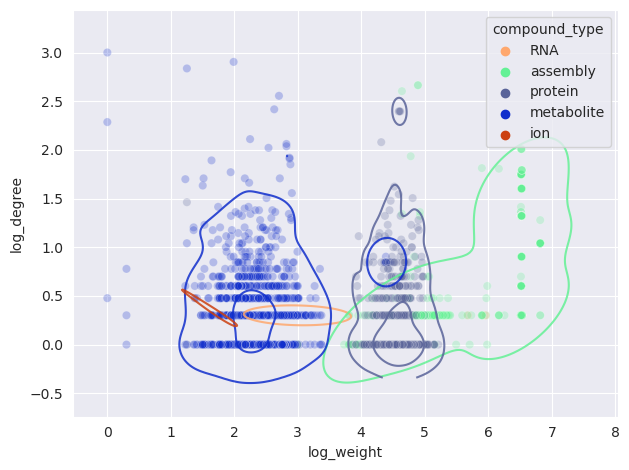

In [18]:
fig, ax=plt.subplots(1)
sns.kdeplot(data=full_network_attributes.query('compound_type != "placeholder"'), 
hue='compound_type', x='log_weight', y='log_degree', palette=palette, alpha=0.85, ax=ax, levels=3, bw_adjust=1.25)
g = sns.scatterplot(data=full_network_attributes.query('compound_type != "placeholder"'), 
hue='compound_type', x='log_weight', y='log_degree', palette=palette, alpha=0.25, ax=ax)
plt.tight_layout()
#plt.savefig('./figures/fig-mass-degree.svg')


**Figure S3**. Degree versus mass distribution depending on the type of compound.

In [19]:
network_attributes_by_domain = pd.concat([
    translation_network_attributes, 
    metabolism_network_attributes, 
    biosynthesis_network_attributes
]).reset_index()
network_attributes_by_domain['logweight'] = np.log10(network_attributes_by_domain['weight'])

/home/bcz/miniconda3/envs/tn2022/lib/python3.11/site-packages/seaborn/distributions.py:407: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"
/tmp/ipykernel_2830592/2473094230.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(["" * 9])


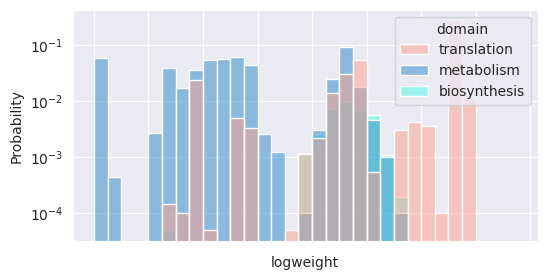

In [20]:
bins = np.arange(0, 8, 0.25)

fig, ax = plt.subplots(1)
fig.set_size_inches(6.0, 3.0)
g = sns.histplot(
    hue='domain', x='logweight', data=network_attributes_by_domain, palette=dict(translation='#FF9E8C', metabolism='#298ACC', biosynthesis='#4DFFE6'), 
    bins=bins, stat='probability', ax=ax, weights='degree_total', log_scale=(False, True)
)
g.set_xticklabels(["" * 9])
# plt.savefig('mass_by_domain.svg')
plt.show()

**Figure 5C**. Degree-weighted distribution of the mass depending on the layer.

### Extracting individual components

Due to some operational issues, we have generated this plot by recomputing the mass of each of the specific compounds. This also helps to check that the network construction proceeded alright.

In [21]:
def compute_molecular_weight(x):
    
    try:
        if x.type  == 'acyl-tRNA':
            return molecular_weight(Seq(x.ntseq).transcribe(), seq_type='RNA')
        elif x.type == 'metabolite': 
            return ExactMolWt(chem.MolFromSmiles(x.smiles))
        elif x.type == 'protein':
            return molecular_weight(x.aaseq, seq_type='protein')
        elif x.type == 'RNA':
            return molecular_weight(Seq(x.ntseq).transcribe(), seq_type='RNA')
        else:
            return None
    except:
        return 0.0


In [22]:
translation_components = pd.read_csv('./data/translation_components.csv', sep=';').query('type != "acyl-tRNA" and type != "assembly" and type != "placeholder"')
translation_components.geneid = translation_components.geneid.apply(lambda x: x.split(',')[0] if pd.isna(x) == False else None)
translation_components
metabolic_gene_components = pd.read_json('./data/kegg.gene.anotation.json').T.reset_index()
metabolic_gene_components = metabolic_gene_components.rename(columns={"index":"id"})
metabolic_gene_components['type'] = 'protein'
metabolic_gene_components[:10]
metabolic_metabolite_components = pd.read_json('./data/kegg.compound.anotation.json').T
metabolic_metabolite_components = metabolic_metabolite_components.reset_index().rename(columns={'index':"id"})
metabolic_metabolite_components['type'] = 'metabolite'
metabolic_metabolite_components[:10]
joint_table = pd.concat(
    [translation_components[['id', 'type', 'aaseq', 'ntseq', 'mass', 'geneid']], 
    metabolic_gene_components[['id', 'type', 'aaseq', 'ntseq']], 
    metabolic_metabolite_components[['id', 'type', 'smiles']]]
).reset_index()
joint_table['molecular_weight'] = joint_table.apply(compute_molecular_weight, axis=1)
joint_table['molecular_weight'] = joint_table.apply(lambda x: x.molecular_weight if pd.isna(x.mass) else x.mass, axis=1)
joint_table['log_molecular_weight'] = np.log10(joint_table['molecular_weight'])
joint_table = joint_table.set_index('id')
joint_table

[15:03:55] SMILES Parse Error: unclosed ring for input: 'C02869'
[15:03:55] SMILES Parse Error: unclosed ring for input: 'C02745'
[15:03:55] WARNING: not removing hydrogen atom without neighbors
[15:03:55] SMILES Parse Error: unclosed ring for input: 'C01834'
[15:03:55] SMILES Parse Error: unclosed ring for input: 'C01635'
[15:03:55] SMILES Parse Error: unclosed ring for input: 'C01636'
[15:03:55] SMILES Parse Error: unclosed ring for input: 'C01637'
[15:03:55] SMILES Parse Error: unclosed ring for input: 'C01638'
[15:03:55] SMILES Parse Error: unclosed ring for input: 'C01639'
[15:03:55] SMILES Parse Error: duplicated ring closure 0 bonds atom 0 to itself for input: 'C01640'
[15:03:55] SMILES Parse Error: unclosed ring for input: 'C01641'
[15:03:55] SMILES Parse Error: unclosed ring for input: 'C01642'
[15:03:55] SMILES Parse Error: unclosed ring for input: 'C01643'
[15:03:55] SMILES Parse Error: unclosed ring for input: 'C01644'
[15:03:55] SMILES Parse Error: unclosed ring for input:

,index,type,aaseq,ntseq,mass,geneid,smiles,molecular_weight,log_molecular_weight
id,,,,,,,,,
magnesium,28,ion,NaN,NaN,24.0,None,None,24.000000,1.380211
manganese,29,ion,NaN,NaN,54.9,None,None,54.900000,1.739572
pi,30,ion,NaN,NaN,97.0,None,None,97.000000,1.986772
zinc,31,ion,NaN,NaN,65.4,None,None,65.400000,1.815578
4fe4s,32,metabolite,NaN,NaN,351.4,None,None,351.400000,2.545802
...,...,...,...,...,...,...,...,...,...
xu5p-L,1035,metabolite,NaN,NaN,NaN,NaN,O=C(CO)[C@H](O)[C@@H](O)COP(=O)(O)O,230.019154,2.361764
xyl-D,1036,metabolite,NaN,NaN,NaN,NaN,OC1OC[C@@H](O)[C@H](O)[C@H]1O,150.052823,2.176244
xylu-D,1037,metabolite,NaN,NaN,NaN,NaN,OCC1(O)OC[C@@H](O)[C@@H]1O,150.052823,2.176244


In [23]:
full_network = nx.read_gml('networks/full-network.gml')
with open('data/alias.json') as f:
    alias = json.load(f)
alias = [dict(id=id, components=values.split(',')) for id, values in alias.items()]
alias = pd.DataFrame.from_records(alias).set_index('id')
joint_table['degree'] = 0

for node, node_data in filter(lambda x: x[1]['type'] == 'chemical_entity', full_network.nodes(data=True)):

    degree = full_network.degree[node]
    components = re.split('\s\*\s|\s-\s', node)
    subcomponents = []
    for comp in components:
        try:
            subcomponents += alias.loc[comp, 'components']
        except:
            subcomponents += [comp]
    
    for subcomponent in subcomponents:
        try:
            joint_table.loc[subcomponent, 'degree'] += degree
        except KeyError:
            continue
    
    

/home/bcz/miniconda3/envs/tn2022/lib/python3.11/site-packages/seaborn/distributions.py:407: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"


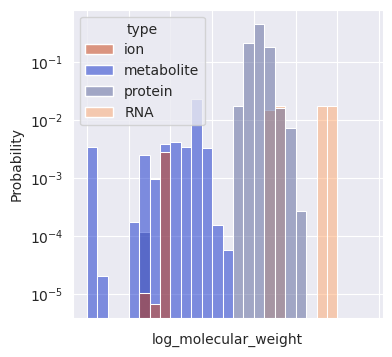

In [24]:
fig, ax = plt.subplots(1)
fig.set_size_inches(4, 4)
ax = sns.histplot(
    x='log_molecular_weight', weights='degree', data=joint_table.reset_index(), hue='type', log_scale=(False, True), bins=np.arange(0, 7, 0.25), stat='probability', palette=palette
)
ax.set_xticks([0, 1, 2, 3, 4, 5, 6, 7])
ax.set_xticklabels([])
plt.show()
# plt.savefig('figures/mass-weighted-by-degree.svg')

## Network Embeddings 

In [25]:
from torch_geometric.utils import from_networkx
from torch_geometric.nn import Node2Vec
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import torch

ModuleNotFoundError: No module named 'torch_geometric'

In [ ]:
TMN = nx.read_gml('networks/full-network.gml')
TMN_copy = TMN.copy()

In [ ]:
# Include biosynthesis

type_dict = dict(
    chemical_entity=[1, 0],
    chemical_reaction=[0, 1]
)
domain_dict = dict(
    metabolism = 1,
    translation = 2,
    biosynthesis = 3
)

def empty_node(x):
    x['x'] = type_dict[x['type']]
    try:
        x['y'] = domain_dict[x['domain']]
    except KeyError:
        x['y'] = 0

    keys = list(x.keys())
    for t in keys:
        if t not in ['x', 'y']:
            del x[t]


for node, node_data in TMN.nodes(data=True): empty_node(node_data)

for _, _, edge_data in TMN.edges(data=True):
    edge_data.clear()

data = from_networkx(TMN)
data.train_mask = torch.gt(torch.rand(len(data.x)), 0.75).to(torch.bool)
data.test_mask = (~ data.train_mask).to(torch.bool)
# data.y = torch.tensor([x['type'] for _, x in TMN.nodes(data=True)], dtype=torch.int32)

In [ ]:
# CHANGE TO CPU IF YOU DON'T HAVE A GPU
device = 'cuda:0'
model = Node2Vec(
    data.edge_index, embedding_dim=128, walk_length=20,
    context_size=10, walks_per_node=10,
    num_negative_samples=5, p=1, q=0.5, sparse=True
).to(device)

loader = model.loader(batch_size=128, shuffle=True, num_workers=4)
optimizer = torch.optim.SparseAdam(list(model.parameters()), lr=0.01)


In [ ]:
def train():
    model.train()
    total_loss = 0
    for pos_rw, neg_rw in loader:
        optimizer.zero_grad()
        loss = model.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

@torch.no_grad()
def test():
    model.eval()
    z = model()
    acc = model.test(z[data.train_mask], data.y[data.train_mask],
                        z[data.test_mask], data.y[data.test_mask],
                        max_iter=150)
    return acc

for epoch in range(1, 101):
    loss = train()
    acc = test()
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Acc: {acc:.4f}')

In [ ]:
c = [node_data['y'] for _, node_data in TMN.nodes(data=True)]
z = model(torch.arange(data.num_nodes, device=device))
z = TSNE(n_components=2).fit_transform(z.detach().cpu().numpy())
# km = KMeans(n_clusters=16).fit(z)
# km.labels_

In [ ]:
c = np.array(c)
fig, ax = plt.subplots(1)
fig.set_size_inches(7, 7)
ax.set_aspect('equal')
ax.scatter(z[c==1, 0], z[c==1,1], c='#4DFFE6',  alpha=0.5, lw=0.25, edgecolors='black')
ax.scatter(z[c==2, 0], z[c==2,1], c='#FF9E8C',  alpha=0.5, lw=0.25, edgecolors='black')
ax.scatter(z[c==0, 0], z[c==0,1], c='gray',  alpha=0.5, lw=0.25, edgecolors='black')
ax.scatter(z[c==3, 0], z[c==3,1], c='#298ACC',  alpha=0.5, lw=0.25, edgecolors='black')
ax.set_xlabel('t-SNE (first component)')
ax.set_ylabel('t-SNE (second component)')
plt.savefig('figures/fig002.node2vec-tsne.svg', dpi=300)
plt.show()

In [ ]:
for i, (_, node_data) in enumerate(TMN_copy.nodes(data=True)):
    
    node_data['x'] = float(z[i, 0])
    node_data['y'] = float(z[i, 1])

nx.write_gml(TMN_copy, 'networks/full-network.node2vec.gml') 

## Network clustering

The following blocks prunes a metabolic-translation network to generate the network depicted in the Figure 4.

In [29]:
MN = nx.read_gml('networks/metabolism.gml')
TN = nx.read_gml('networks/translation.gml')

In [30]:
def group_bipartite(G, map):
    H = nx.DiGraph()
    for node, node_data in filter(lambda x: x[0] in map.keys(), G.nodes(data=True)):
        m = map[node]
        try:
            node_data = H.nodes[m]
        except KeyError:
            H.add_node(m, grouped=True, size=0, domain=node_data['domain']) #HARDCODED
            node_data = H.nodes[m]
        node_data = H.nodes()[m]
        node_data['size'] += 1

    for node, node_data in filter(lambda x: x[0] not in map.keys(), G.nodes(data=True)):
        H.add_node(node, grouped=False, **node_data)

    for start_node, end_node, _ in G.edges(data=True):

        try:
            _ = H.nodes[start_node]
        except KeyError:
            start_node = map[start_node]

        try:
            _ = H.nodes[end_node]
        except KeyError:
            end_node = map[end_node]

        try:
            edge_data = H.edges[start_node, end_node]
        except KeyError:
            H.add_edge(start_node, end_node, weight=0)
            edge_data = H.edges[start_node, end_node]
        edge_data['weight'] += 1
    H.remove_edges_from(nx.selfloop_edges(H))
    return H


def cluster_in(G, map):
    H = nx.DiGraph()
    map_values = list(map.values())
    for node, node_data in filter(lambda x: x[0] in map_values, G.nodes(data=True)):
        H.add_node(node, **node_data)

    for node, node_data in filter(lambda x: x[0] not in map_values, G.nodes(data=True)):
        interacts_with = list(set(list(G.pred[node]) + list(G.succ[node])))
        print(interacts_with)
        if len(interacts_with) == 1:
            if interacts_with in map_values:
                H[map[interacts_with]]['size'] += 1
        else:
            H.add_node(node, **node_data)


    for start_node, end_node, edge_data in G.edges(data=True):

        try:
            H.nodes[start_node]
            H.nodes[end_node]
        except KeyError:
            continue
        
        H.add_edge(start_node, end_node, **edge_data)
    
    return H
    

In [31]:
module_map = dict()
domain_map = dict()
MTN = nx.compose(MN, TN)

for node, node_data in filter(lambda x: x[1]['type'] == "chemical_reaction", MTN.nodes(data=True)):
    try:
        module_map[node] = node_data['module']
    except KeyError:
        continue
    domain_map[node] =  node_data['domain']

In [32]:
MTN_CG = group_bipartite(MTN, module_map)
MTN_CG = cluster_in(MTN_CG, module_map)

['canonical-termination']
['canonical-termination']
['canonical-termination']
['canonical-termination']
['canonical-termination']
['cognate.elongation', 'canonical-termination']
['canonical-termination']
['canonical-termination']
['cognate.elongation', 'canonical-termination']
['canonical-termination']
['cognate.elongation', 'canonical-termination']
['canonical-termination']
['cognate.elongation', 'canonical-termination']
['canonical-termination']
['cognate.elongation', 'canonical-termination']
['canonical-termination']
['cognate.elongation', 'canonical-termination']
['canonical-termination']
['cognate.elongation', 'canonical-termination']
['canonical-termination']
['cognate.elongation', 'canonical-termination']
['canonical-termination']
['cognate.elongation', 'canonical-termination']
['canonical-termination']
['cognate.elongation', 'canonical-termination']
['canonical-termination']
['cognate.elongation', 'canonical-termination']
['canonical-termination']
['cognate.elongation', 'canoni

In [33]:
nx.write_gml(MTN_CG, 'networks/coarse-grained-full-network.gml')